## Telco Customer Churn - Part 1: Advanced Exploratory Data Analysis (EDA)

In [2]:
!pip install -q -r requirements.txt

## 1. Imports and display settings

In [3]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

warnings.filterwarnings('ignore')

#### Display options

In [4]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)
plt.rcParams['figure.figsize'] = (10,6)

### 1.1 Initial Data Assessment
 - Data quality checks, missing values, data types
 - Target variable analysis (churn rate & class imbalance)
 - Feature overview (categorize into groups)

#### 1.1.1 Load data and first look

In [5]:
file_path = 'src/data/raw/telco-customer-churn-raw.csv'
df = pd.read_csv(file_path)

In [5]:
print('Shape:', df.shape)
df.head()

Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


#### 1.1.2 Data types and missing values

In [6]:
print(df.info())
print('\nMissing values per column:')
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


TotalCharges may be read as object due to whitespace so need to convert it

##### Clean TotalCharges: convert to numeric, coerce errors then inspect

In [7]:
if df['TotalCharges'].dtype == 'object':
    df['TotalCharges'] = df['TotalCharges'].str.strip()
    
    # convert empty strings to NaN
    df['TotalCharges'].replace('', np.nan, inplace=True)
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

print('\nAfter conversion:')
print(df['TotalCharges'].dtype, '  Nulls:', df['TotalCharges'].isnull().sum())


After conversion:
float64   Nulls: 11


Inspect rows with missing TotalCharges

In [8]:
missing_total = df[df['TotalCharges'].isnull()]
if not missing_total.empty:
    print('\nSample rows with missing TotalCharges:')
    display(missing_total.head())


Sample rows with missing TotalCharges:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No


#### 1.1.3 Target variable analysis: churn rate & imbalance

Calculate churn rate

In [9]:
churn_counts = df['Churn'].value_counts()
churn_rate = churn_counts['Yes'] / churn_counts.sum()
imbalance_ratio = churn_counts['No'] / churn_counts['Yes']
print('Churn counts:\n', churn_counts)
print('\nChurn rate: {:.2%}'.format(churn_rate))
print('Imbalance ratio (No:Yes) = {:.2f}:1'.format(imbalance_ratio))

Churn counts:
 Churn
No     5174
Yes    1869
Name: count, dtype: int64

Churn rate: 26.54%
Imbalance ratio (No:Yes) = 2.77:1


Quick bar chart of churn distribution

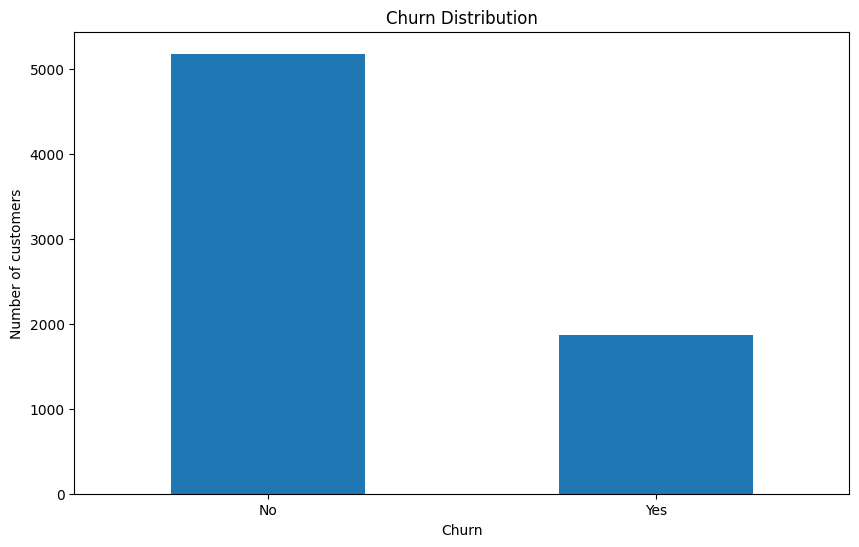

In [10]:
churn_counts.plot(kind='bar', rot=0)
plt.title('Churn Distribution')
plt.ylabel('Number of customers')
plt.show()

#### 1.1.4 Feature categorization

In [11]:
DEMOGRAPHIC = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']
ACCOUNT = ['tenure', 'Contract', 'PaperlessBilling', 'PaymentMethod']
SERVICES = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
            'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
FINANCIAL = ['MonthlyCharges', 'TotalCharges']

print('Demographic features:', DEMOGRAPHIC)
print('Account features:', ACCOUNT)
print('Service features:', SERVICES)
print('Financial features:', FINANCIAL)

Demographic features: ['gender', 'SeniorCitizen', 'Partner', 'Dependents']
Account features: ['tenure', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Service features: ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
Financial features: ['MonthlyCharges', 'TotalCharges']


### 1.2 Class Imbalance Analysis

#### 1.2.1 Visualizations: pie + normalized bar per churn

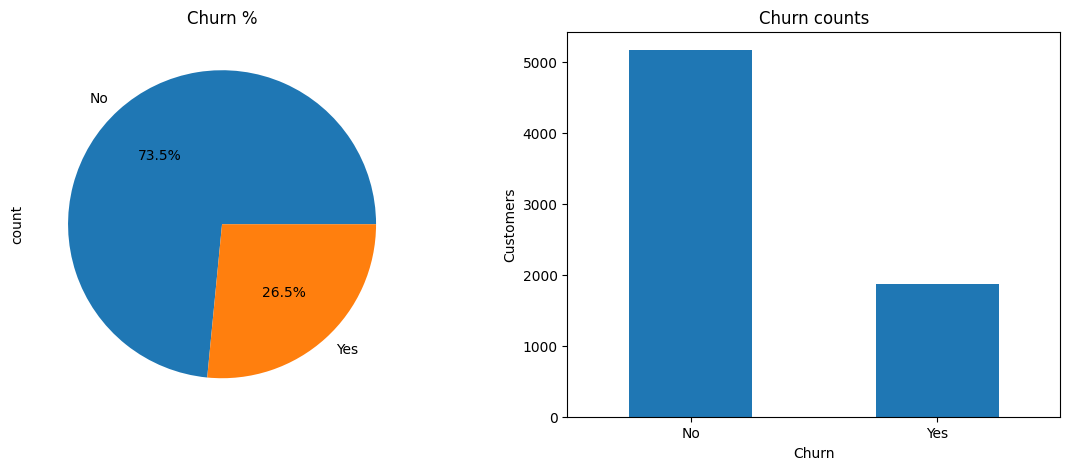

In [12]:
fig, axes = plt.subplots(1,2, figsize=(14,5))
churn_counts.plot(kind='pie', autopct='%1.1f%%', ax=axes[0], title='Churn %')
churn_counts.plot(kind='bar', rot=0, ax=axes[1], title='Churn counts')
axes[1].set_ylabel('Customers')
plt.show()

#### 1.2.2 Impact note (print statement for report)

Class imbalance notes:
- Churn is typically the minority class; many models will favour predicting the majority class.
- This affects metrics: solely depending on accuracy can be misleading; so we can use precision/recall, F1 score, ROC-AUC, PR-AUC.
- Consider strategies: resampling using (SMOTE/undersampling), class weights, anomaly-detection framing, threshold tuning.

#### 1.2.3 Analyze churn rates across segments: 

##### 1.2.3.1 For Contract types

In [13]:
contract_churn = df.groupby('Contract')['Churn'].value_counts(normalize=True).unstack().fillna(0)
print('\nContract churn proportions:')
print(contract_churn)


Contract churn proportions:
Churn                 No       Yes
Contract                          
Month-to-month  0.572903  0.427097
One year        0.887305  0.112695
Two year        0.971681  0.028319


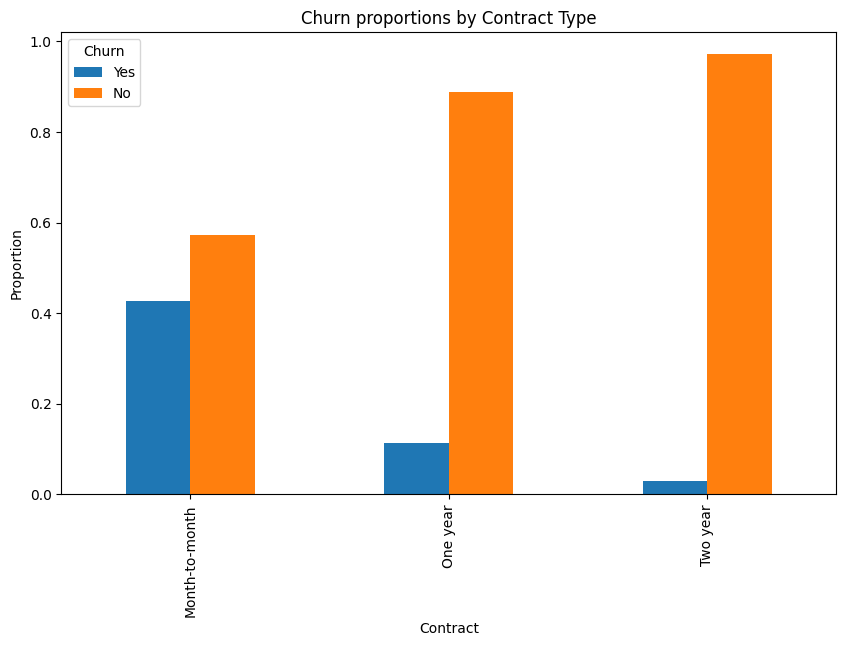

In [14]:
contract_churn[['Yes','No']].plot(kind='bar', stacked=False)
plt.title('Churn proportions by Contract Type')
plt.ylabel('Proportion')
plt.show()

##### 1.2.3.2 For PaymentMethod

In [15]:
payment_method_churn = df.groupby('PaymentMethod')['Churn'].value_counts(normalize=True).unstack().fillna(0)
print('\nPayment method churn proportions:')
print(payment_method_churn)


Payment method churn proportions:
Churn                            No       Yes
PaymentMethod                                
Bank transfer (automatic)  0.832902  0.167098
Credit card (automatic)    0.847569  0.152431
Electronic check           0.547146  0.452854
Mailed check               0.808933  0.191067


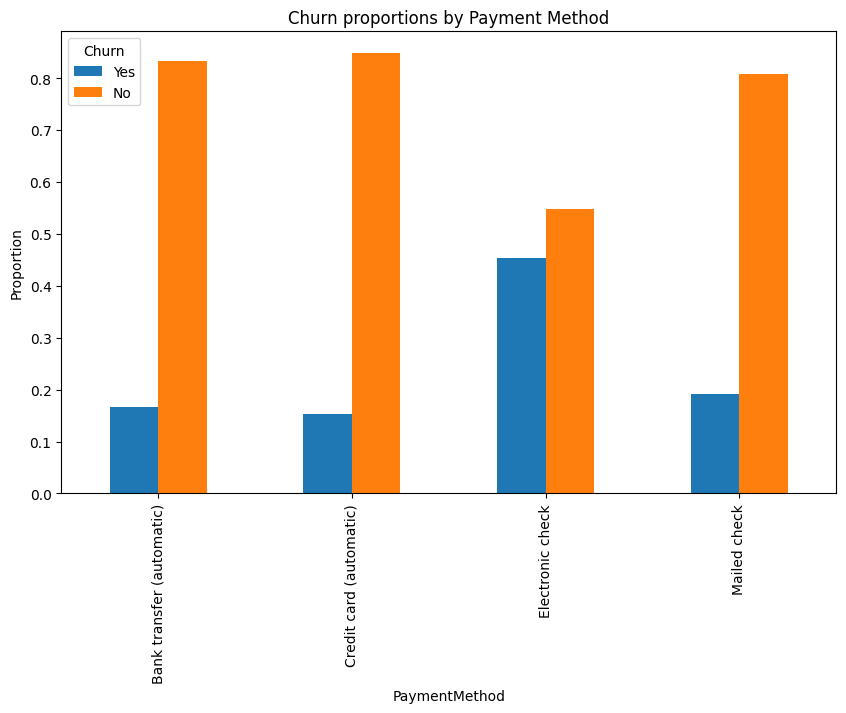

In [16]:
payment_method_churn[['Yes','No']].plot(kind='bar', stacked=False)
plt.title('Churn proportions by Payment Method')
plt.ylabel('Proportion')
plt.show()

##### 1.2.3.3 For InternetService

In [17]:
internet_service_churn = df.groupby('InternetService')['Churn'].value_counts(normalize=True).unstack().fillna(0)
print('\nInternet Service churn proportions:')
print(internet_service_churn)


Internet Service churn proportions:
Churn                  No       Yes
InternetService                    
DSL              0.810409  0.189591
Fiber optic      0.581072  0.418928
No               0.925950  0.074050


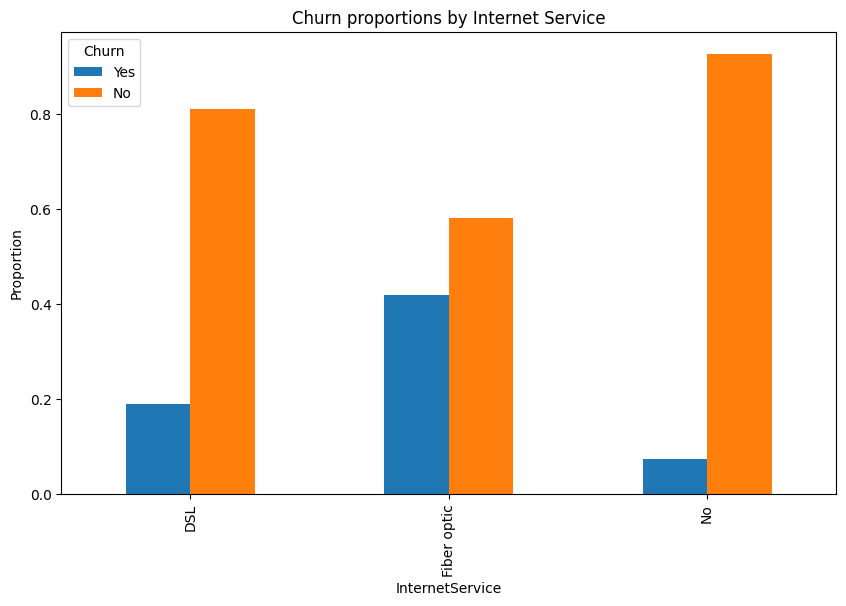

In [18]:
internet_service_churn[['Yes','No']].plot(kind='bar', stacked=False)
plt.title('Churn proportions by Internet Service')
plt.ylabel('Proportion')
plt.show()

##### 1.2.3.4 For SeniorCitizen

In [19]:
senior_citizen_churn = df.groupby('SeniorCitizen')['Churn'].value_counts(normalize=True).unstack().fillna(0)
print('\nSenior Citizen churn proportions:')
print(senior_citizen_churn)


Senior Citizen churn proportions:
Churn                No       Yes
SeniorCitizen                    
0              0.763938  0.236062
1              0.583187  0.416813


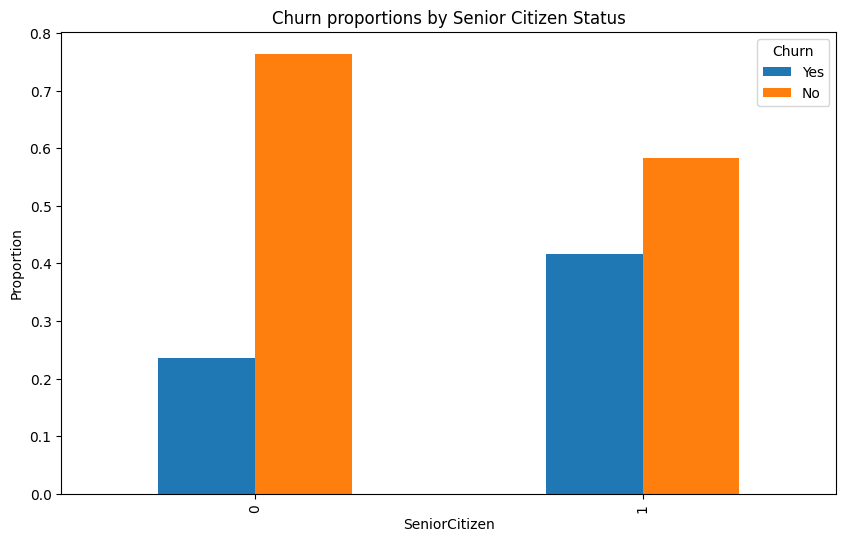

In [20]:
senior_citizen_churn[['Yes','No']].plot(kind='bar', stacked=False)
plt.title('Churn proportions by Senior Citizen Status')
plt.ylabel('Proportion')
plt.show()

##### 1.2.3.5 For Gender

In [21]:
gender_churn = df.groupby('gender')['Churn'].value_counts(normalize=True).unstack().fillna(0)
print('\nGender churn proportions:')
print(gender_churn)


Gender churn proportions:
Churn         No       Yes
gender                    
Female  0.730791  0.269209
Male    0.738397  0.261603


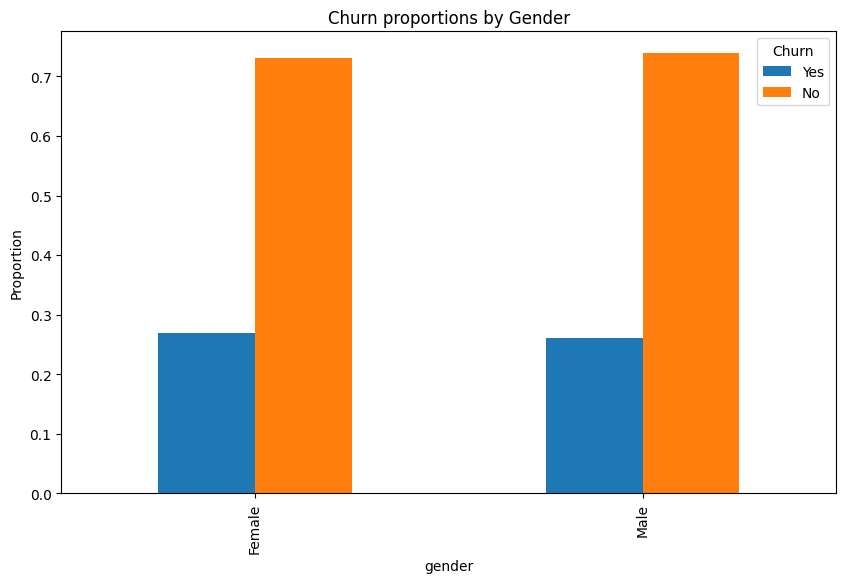

In [22]:
gender_churn[['Yes','No']].plot(kind='bar', stacked=False)
plt.title('Churn proportions by Gender')
plt.ylabel('Proportion')
plt.show()

##### 1.2.3.6 For Partner

In [23]:
partner_churn = df.groupby('Partner')['Churn'].value_counts(normalize=True).unstack().fillna(0)
print('\nPartner churn proportions:')
print(partner_churn)


Partner churn proportions:
Churn          No       Yes
Partner                    
No       0.670420  0.329580
Yes      0.803351  0.196649


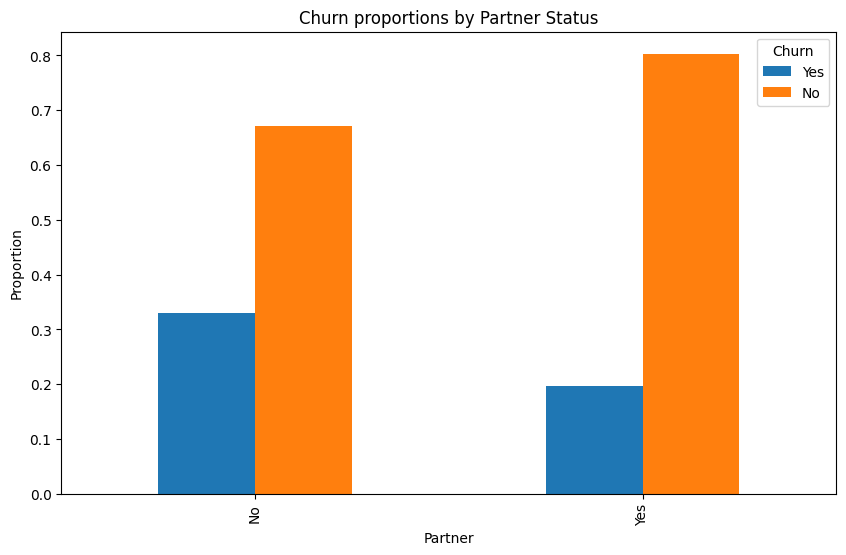

In [24]:
partner_churn[['Yes','No']].plot(kind='bar', stacked=False)
plt.title('Churn proportions by Partner Status')
plt.ylabel('Proportion')
plt.show()

##### 1.2.3.7 For Dependents

In [25]:
dependents_churn = df.groupby('Dependents')['Churn'].value_counts(normalize=True).unstack().fillna(0)
print('\nDependents churn proportions:')
print(dependents_churn)


Dependents churn proportions:
Churn             No       Yes
Dependents                    
No          0.687209  0.312791
Yes         0.845498  0.154502


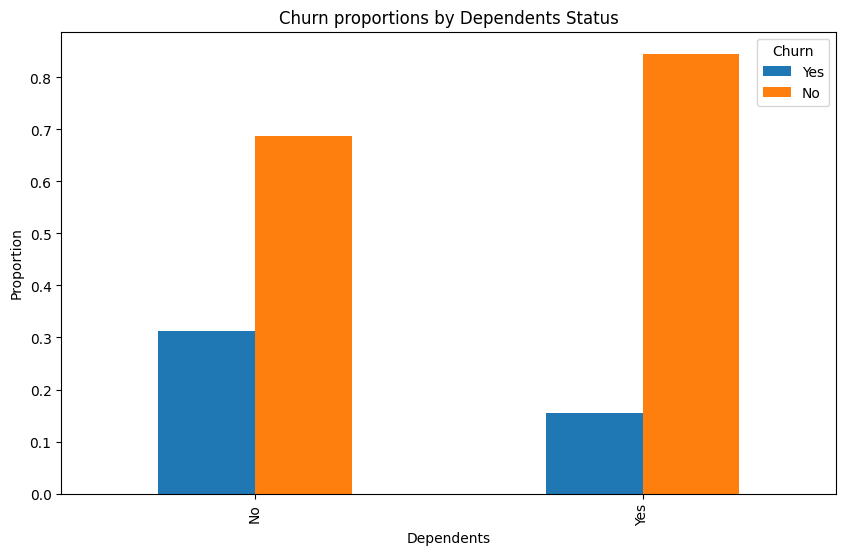

In [26]:
dependents_churn[['Yes','No']].plot(kind='bar', stacked=False)
plt.title('Churn proportions by Dependents Status')
plt.ylabel('Proportion')
plt.show()

##### 1.2.3.8 For MultipleLines

In [27]:
multiple_lines_churn = df.groupby('MultipleLines')['Churn'].value_counts(normalize=True).unstack().fillna(0)
print('\nMultiple Lines churn proportions:')
print(multiple_lines_churn)


Multiple Lines churn proportions:
Churn                   No       Yes
MultipleLines                       
No                0.749558  0.250442
No phone service  0.750733  0.249267
Yes               0.713901  0.286099


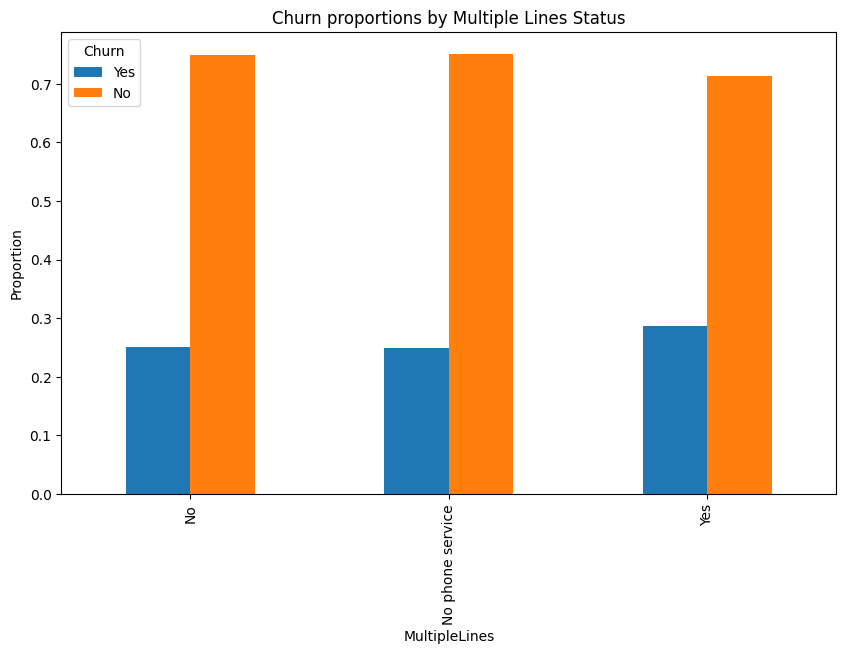

In [28]:
multiple_lines_churn[['Yes','No']].plot(kind='bar', stacked=False)
plt.title('Churn proportions by Multiple Lines Status')
plt.ylabel('Proportion')
plt.show()

##### 1.2.3.9 For OnlineSecurity

In [29]:
online_security_churn = df.groupby('OnlineSecurity')['Churn'].value_counts(normalize=True).unstack().fillna(0)
print('\nOnline Security churn proportions:')
print(online_security_churn)


Online Security churn proportions:
Churn                      No       Yes
OnlineSecurity                         
No                   0.582333  0.417667
No internet service  0.925950  0.074050
Yes                  0.853888  0.146112


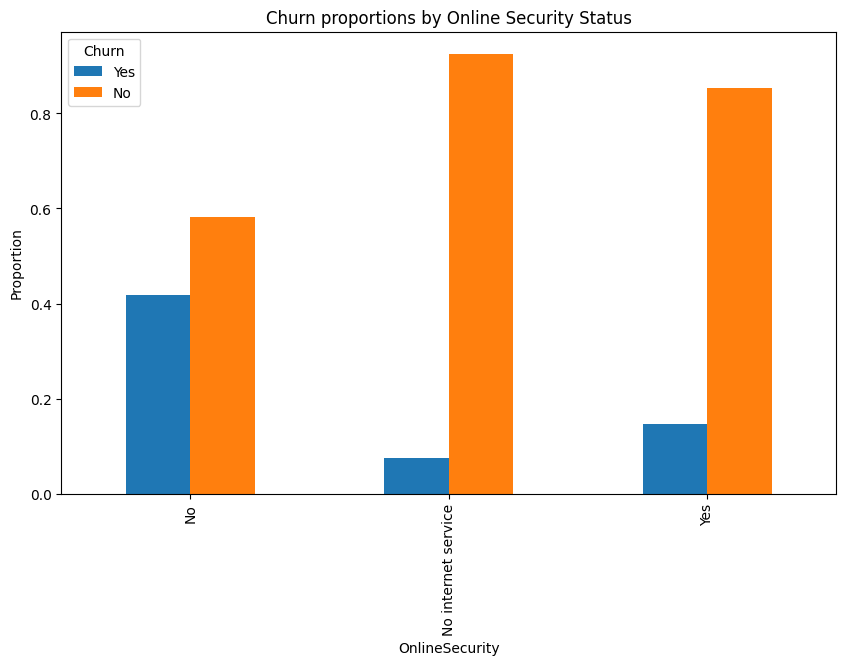

In [30]:
online_security_churn[['Yes','No']].plot(kind='bar', stacked=False)
plt.title('Churn proportions by Online Security Status')
plt.ylabel('Proportion')
plt.show()

in here we can see a major difference in 'No internet services' Churn/Non-churn status

##### 1.2.3.10 For OnlineBackup

In [31]:
online_backup_churn = df.groupby('OnlineBackup')['Churn'].value_counts(normalize=True).unstack().fillna(0)
print('\nOnline Backup churn proportions:')
print(online_backup_churn)


Online Backup churn proportions:
Churn                      No       Yes
OnlineBackup                           
No                   0.600712  0.399288
No internet service  0.925950  0.074050
Yes                  0.784685  0.215315


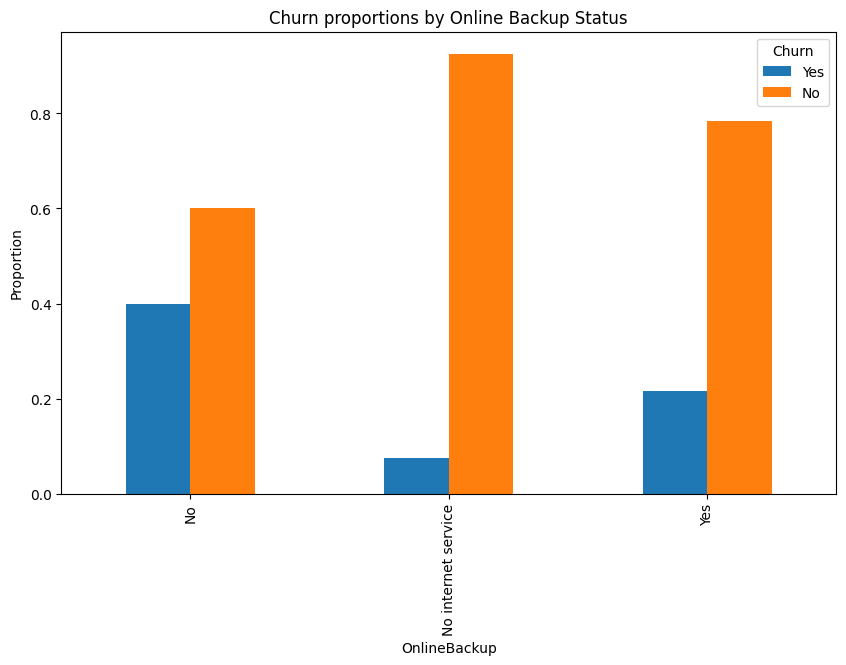

In [32]:
online_backup_churn[['Yes','No']].plot(kind='bar', stacked=False)
plt.title('Churn proportions by Online Backup Status')
plt.ylabel('Proportion')
plt.show()

we can see there is a slight common trends between OnlineBackup and OnlineSecurity statuses.

##### 1.2.3.11 For TechSupport

In [33]:
tech_support_churn = df.groupby('TechSupport')['Churn'].value_counts(normalize=True).unstack().fillna(0)
print('\nTech Support churn proportions:')
print(tech_support_churn)


Tech Support churn proportions:
Churn                      No       Yes
TechSupport                            
No                   0.583645  0.416355
No internet service  0.925950  0.074050
Yes                  0.848337  0.151663


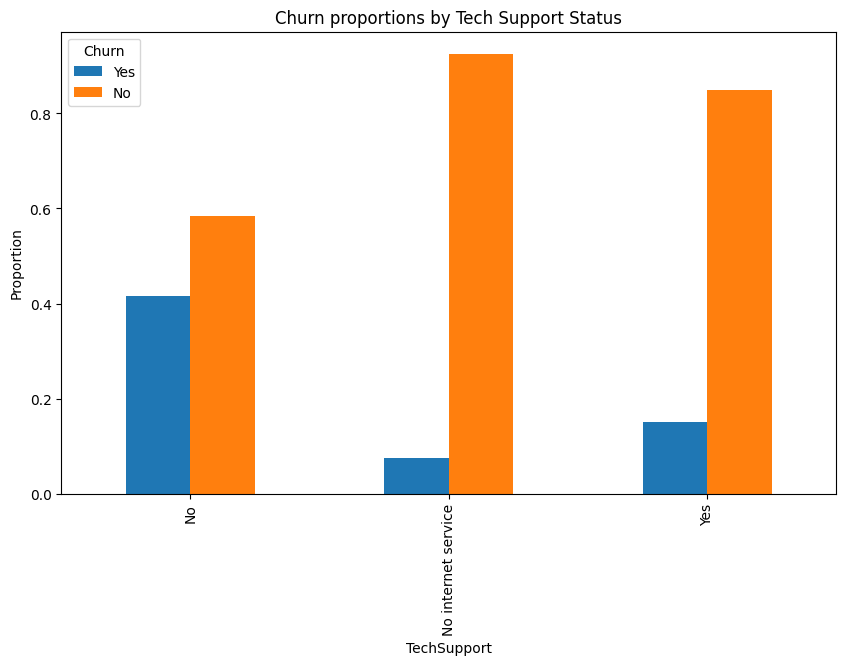

In [34]:
tech_support_churn[['Yes','No']].plot(kind='bar', stacked=False)
plt.title('Churn proportions by Tech Support Status')
plt.ylabel('Proportion')
plt.show()

also we can see there is a common trends between OnlineBackup, OnlineSecurity and TechSupport statuses in 'No internet services' Churn/Non-Churn statuses. They share identical metrics.

### 1.3 Advanced Univariate Analysis

- Numerical features: distributions, skew, outliers (IQR & Z-score)
- Categorical features: frequency and relationship with churn
- Feature engineering


#### 1.3.1 Numerical distributions

In [35]:
num_cols = ['tenure','MonthlyCharges','TotalCharges']
for col in num_cols:
    print('\n---', col)


--- tenure

--- MonthlyCharges

--- TotalCharges


In [36]:
num_cols = ['tenure','MonthlyCharges','TotalCharges']
for col in num_cols:
    display(df[col].describe())
    plt.figure()

count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: TotalCharges, dtype: float64

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

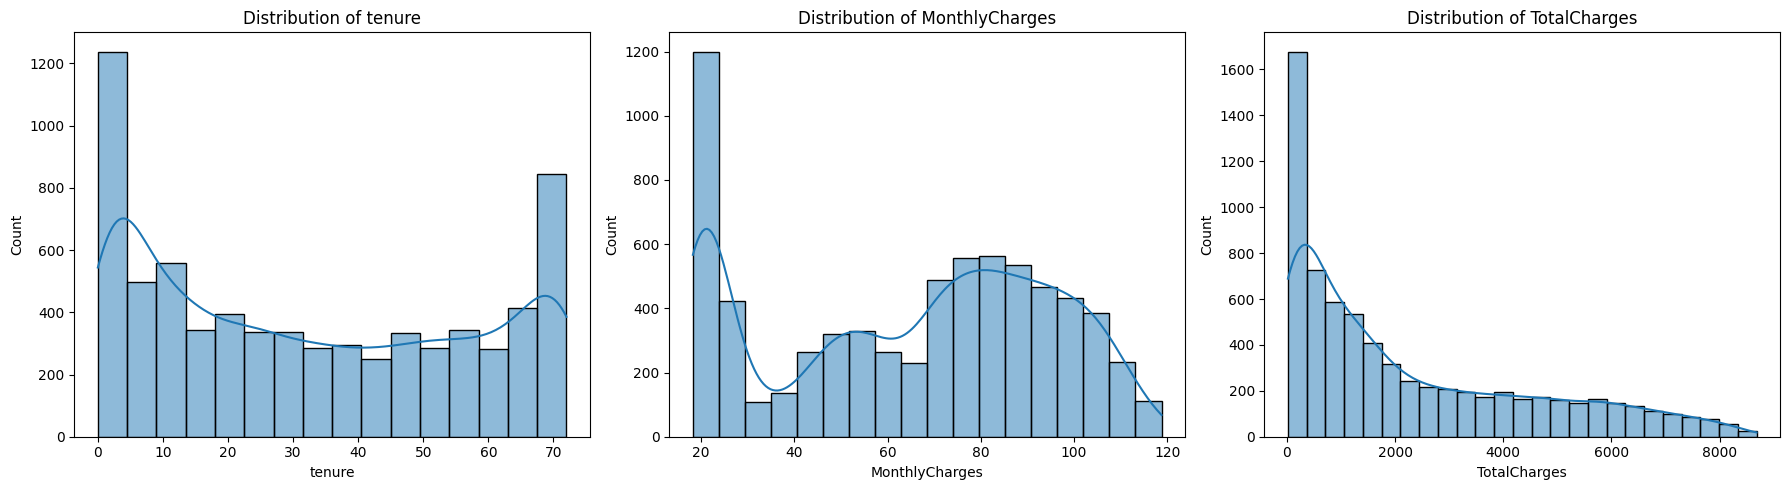

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
for i, col in enumerate(num_cols):
    sns.histplot(df[col].dropna(), kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

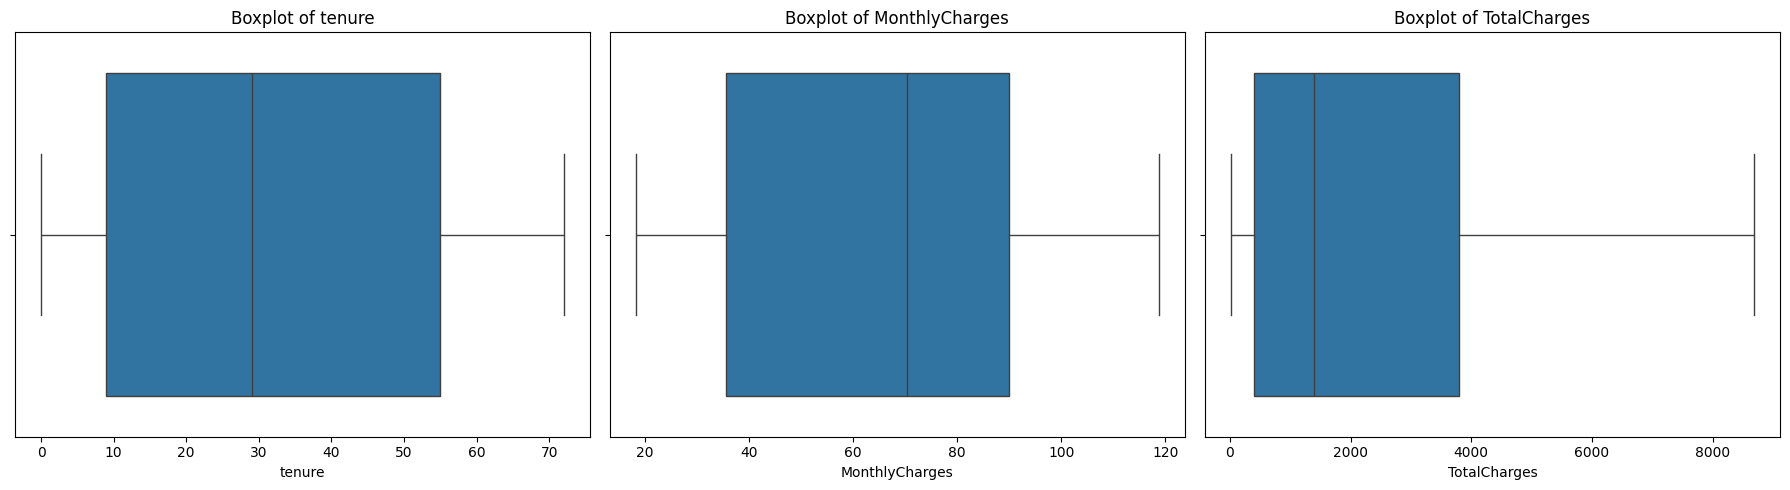

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

num_cols = ['tenure','MonthlyCharges','TotalCharges']
for i, col in enumerate(num_cols):
    sns.boxplot(x=df[col].dropna(), ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

#### 1.3.2 Outlier detection using IQR and Z-score

In [39]:
outlier_summary = {}
for col in num_cols:
    series = df[col].dropna()
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    
    iqr_outliers = series[(series < lower) | (series > upper)]
    zscores = np.abs(stats.zscore(series))
    z_outliers = series[zscores > 3]
    
    outlier_summary[col] = {
        'iqr_outliers_count': len(iqr_outliers),
        'z_outliers_count': len(z_outliers)
    }
    
outlier_summary

{'tenure': {'iqr_outliers_count': 0, 'z_outliers_count': 0},
 'MonthlyCharges': {'iqr_outliers_count': 0, 'z_outliers_count': 0},
 'TotalCharges': {'iqr_outliers_count': 0, 'z_outliers_count': 0}}

#### 1.3.3 Categorical frequency and churn relationship

In [40]:
cat_cols = [c for c in df.columns if df[c].dtype == 'object' and c != 'customerID']
for col in cat_cols:
    print('\n==', col)
    display(df[col].value_counts())


== gender


gender
Male      3555
Female    3488
Name: count, dtype: int64


== Partner


Partner
No     3641
Yes    3402
Name: count, dtype: int64


== Dependents


Dependents
No     4933
Yes    2110
Name: count, dtype: int64


== PhoneService


PhoneService
Yes    6361
No      682
Name: count, dtype: int64


== MultipleLines


MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64


== InternetService


InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64


== OnlineSecurity


OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: count, dtype: int64


== OnlineBackup


OnlineBackup
No                     3088
Yes                    2429
No internet service    1526
Name: count, dtype: int64


== DeviceProtection


DeviceProtection
No                     3095
Yes                    2422
No internet service    1526
Name: count, dtype: int64


== TechSupport


TechSupport
No                     3473
Yes                    2044
No internet service    1526
Name: count, dtype: int64


== StreamingTV


StreamingTV
No                     2810
Yes                    2707
No internet service    1526
Name: count, dtype: int64


== StreamingMovies


StreamingMovies
No                     2785
Yes                    2732
No internet service    1526
Name: count, dtype: int64


== Contract


Contract
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64


== PaperlessBilling


PaperlessBilling
Yes    4171
No     2872
Name: count, dtype: int64


== PaymentMethod


PaymentMethod
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: count, dtype: int64


== Churn


Churn
No     5174
Yes    1869
Name: count, dtype: int64

Churn,No,Yes
gender,,
Female,0.730791,0.269209
Male,0.738397,0.261603


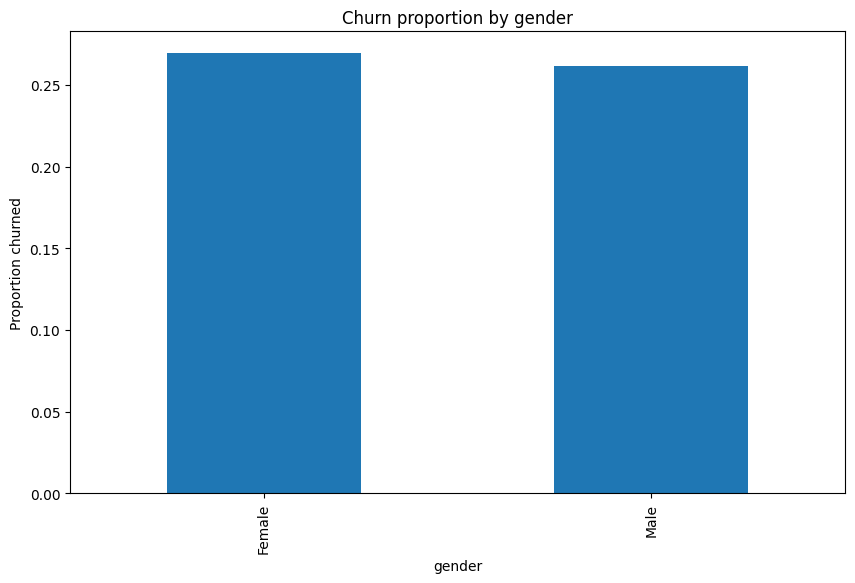

Churn,No,Yes
Partner,,
No,0.670420,0.329580
Yes,0.803351,0.196649


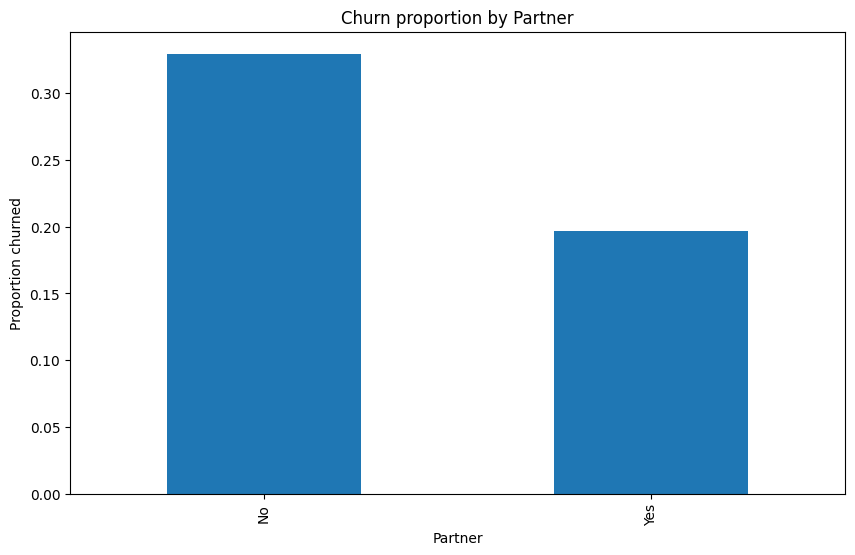

Churn,No,Yes
Dependents,,
No,0.687209,0.312791
Yes,0.845498,0.154502


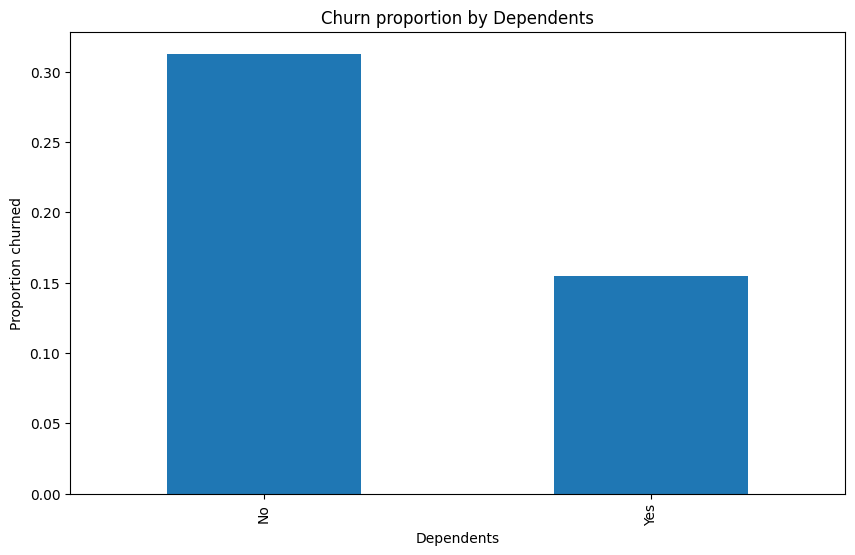

Churn,No,Yes
PhoneService,,
No,0.750733,0.249267
Yes,0.732904,0.267096


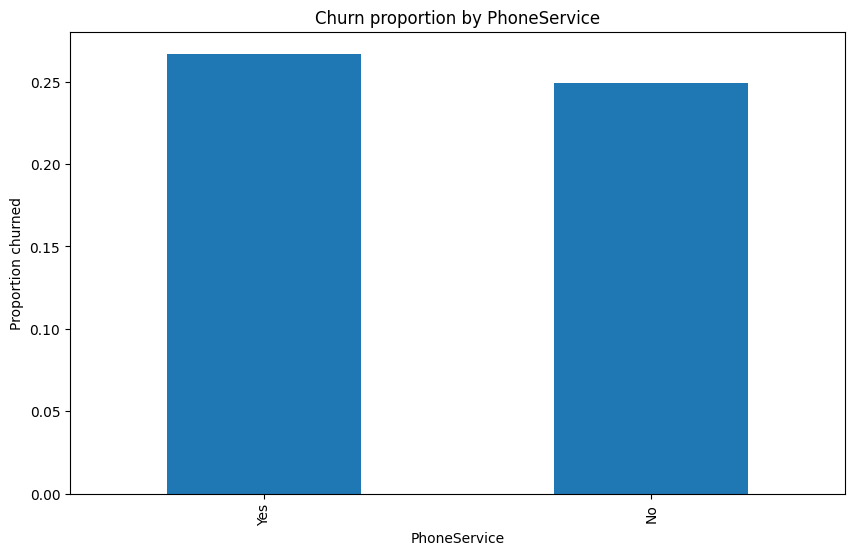

Churn,No,Yes
MultipleLines,,
No,0.749558,0.250442
No phone service,0.750733,0.249267
Yes,0.713901,0.286099


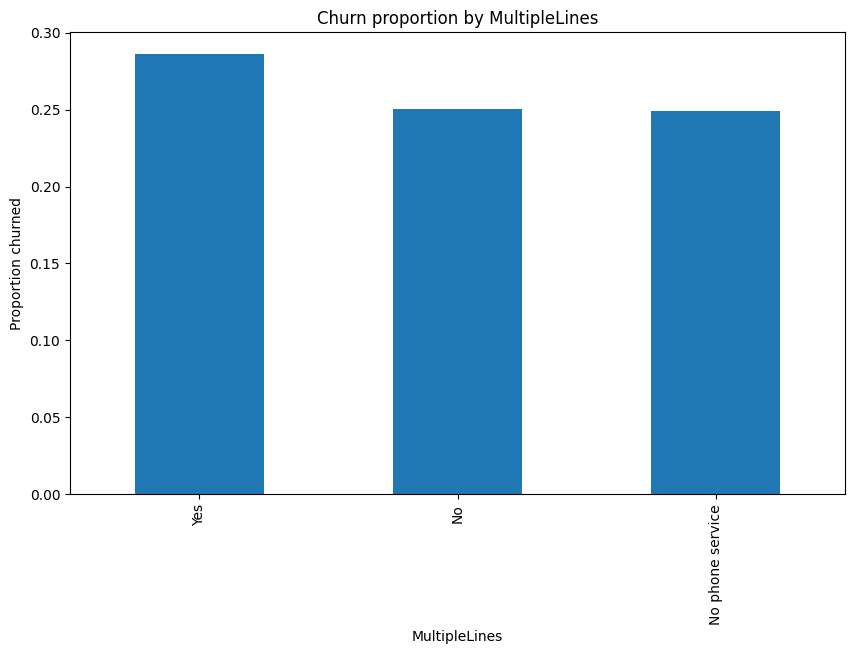

Churn,No,Yes
InternetService,,
DSL,0.810409,0.189591
Fiber optic,0.581072,0.418928
No,0.925950,0.074050


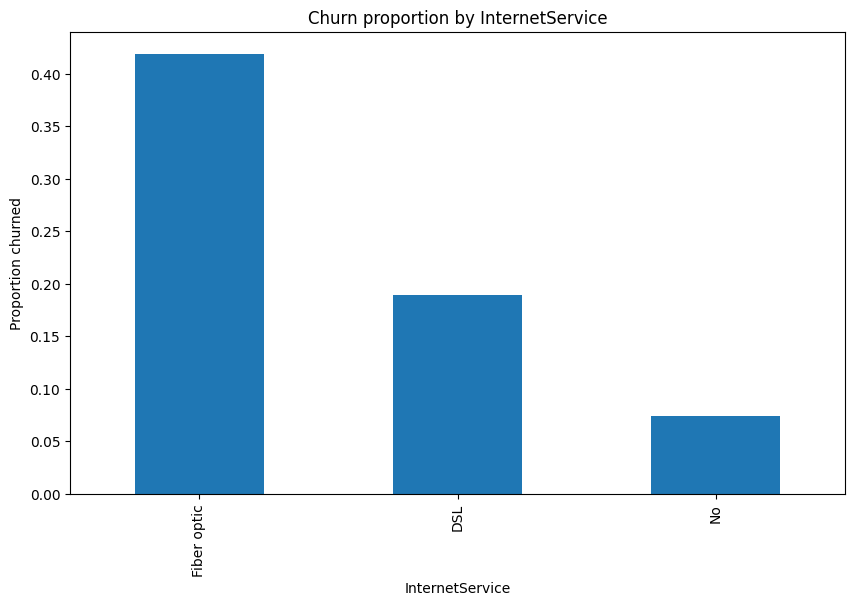

Churn,No,Yes
OnlineSecurity,,
No,0.582333,0.417667
No internet service,0.925950,0.074050
Yes,0.853888,0.146112


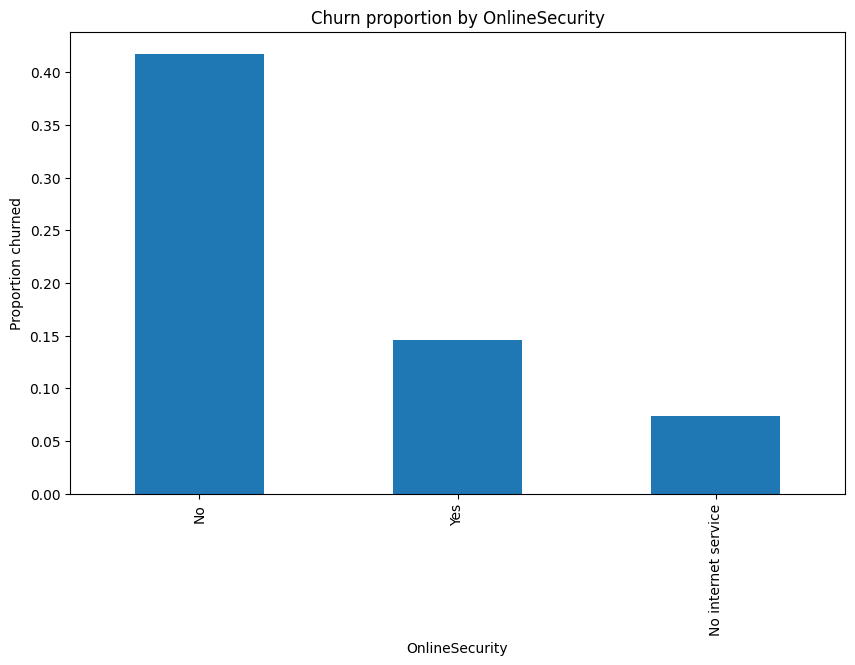

Churn,No,Yes
OnlineBackup,,
No,0.600712,0.399288
No internet service,0.925950,0.074050
Yes,0.784685,0.215315


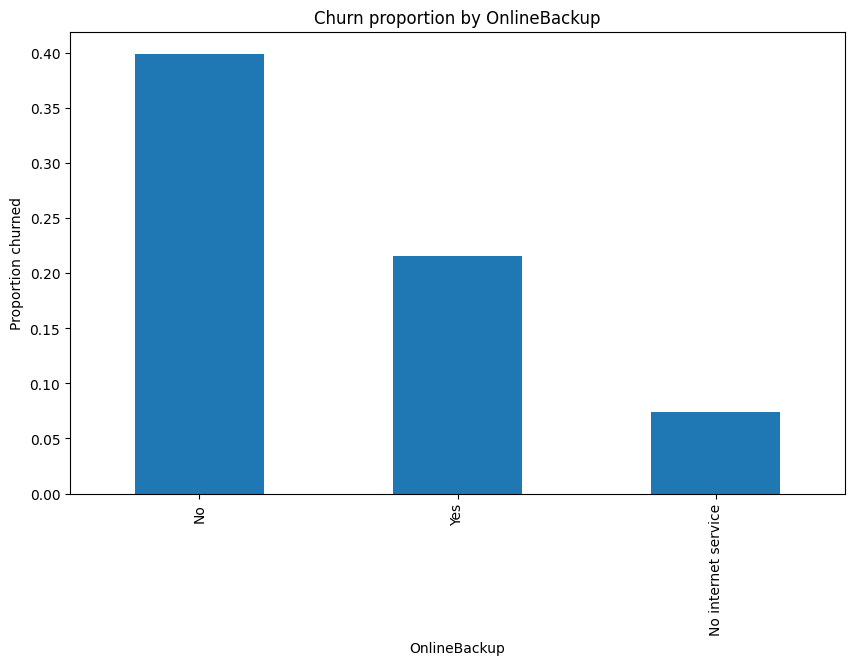

Churn,No,Yes
DeviceProtection,,
No,0.608724,0.391276
No internet service,0.925950,0.074050
Yes,0.774979,0.225021


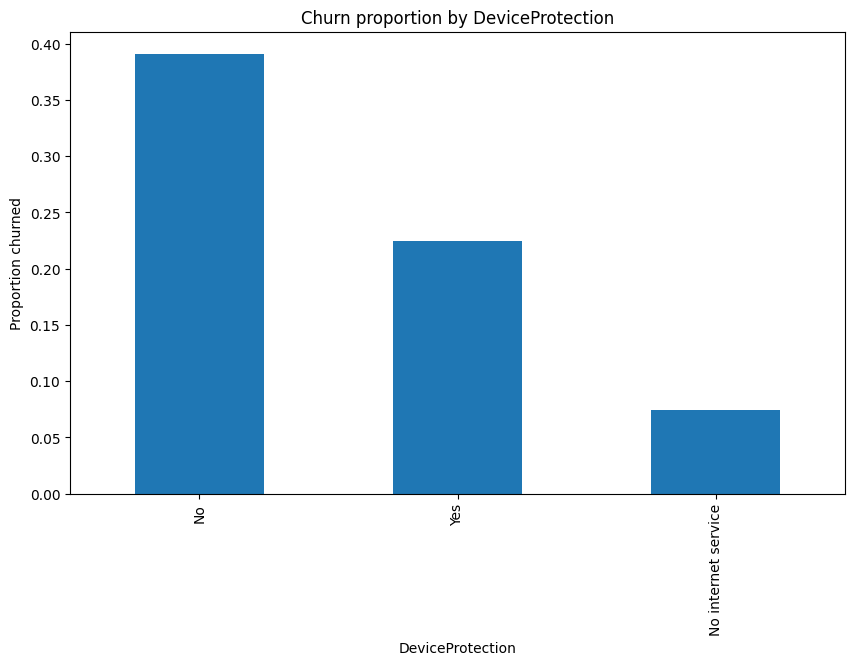

Churn,No,Yes
TechSupport,,
No,0.583645,0.416355
No internet service,0.925950,0.074050
Yes,0.848337,0.151663


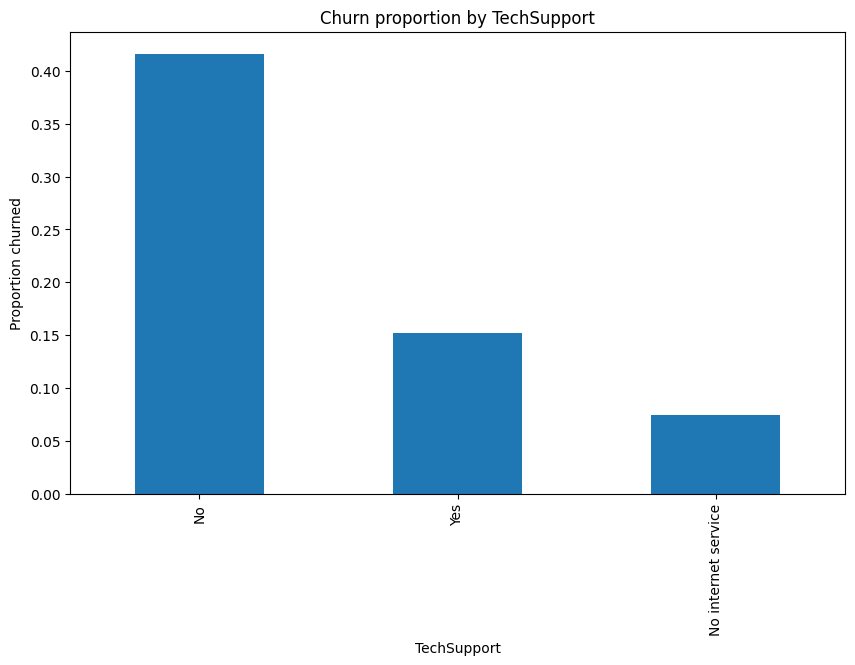

Churn,No,Yes
StreamingTV,,
No,0.664769,0.335231
No internet service,0.925950,0.074050
Yes,0.699298,0.300702


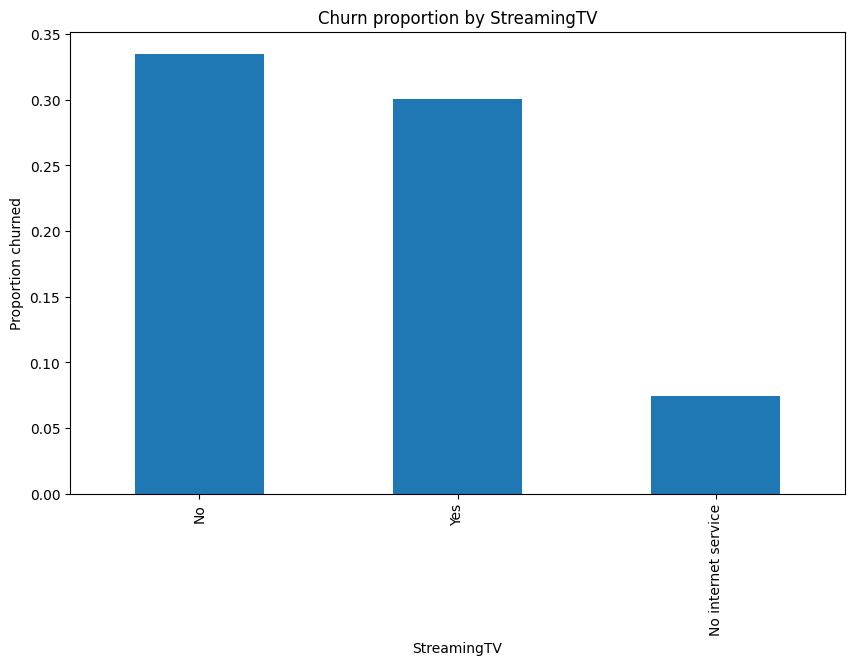

Churn,No,Yes
StreamingMovies,,
No,0.663196,0.336804
No internet service,0.925950,0.074050
Yes,0.700586,0.299414


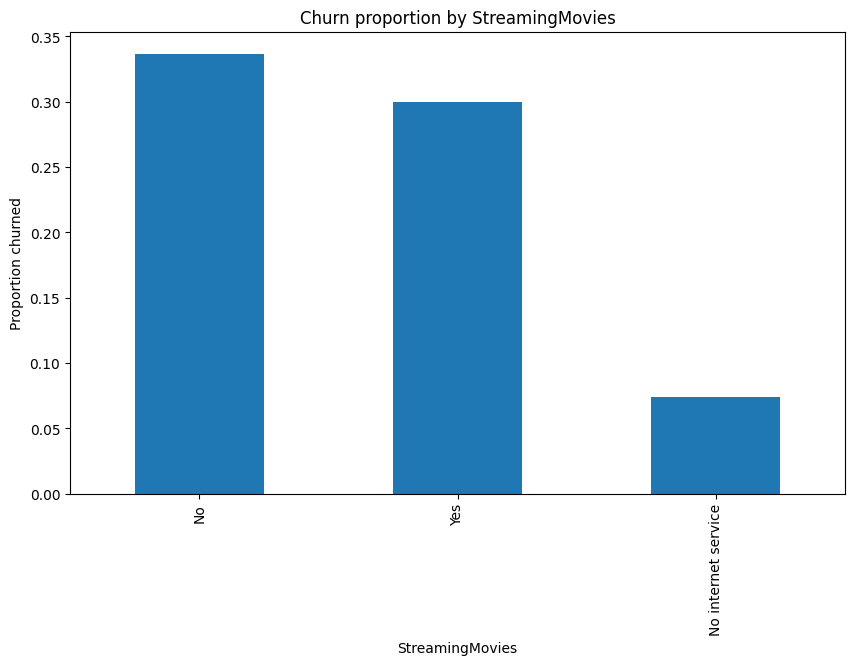

Churn,No,Yes
Contract,,
Month-to-month,0.572903,0.427097
One year,0.887305,0.112695
Two year,0.971681,0.028319


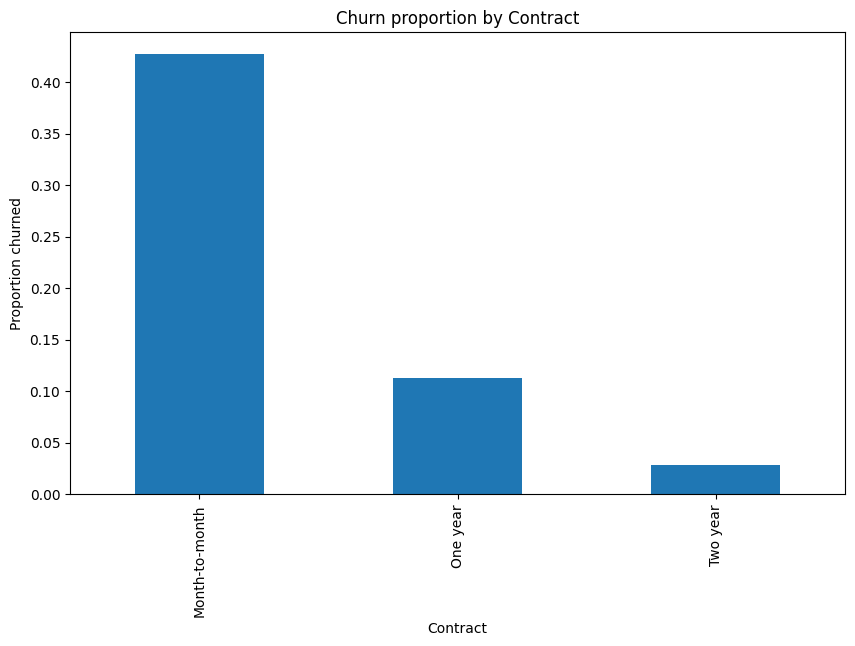

Churn,No,Yes
PaperlessBilling,,
No,0.836699,0.163301
Yes,0.664349,0.335651


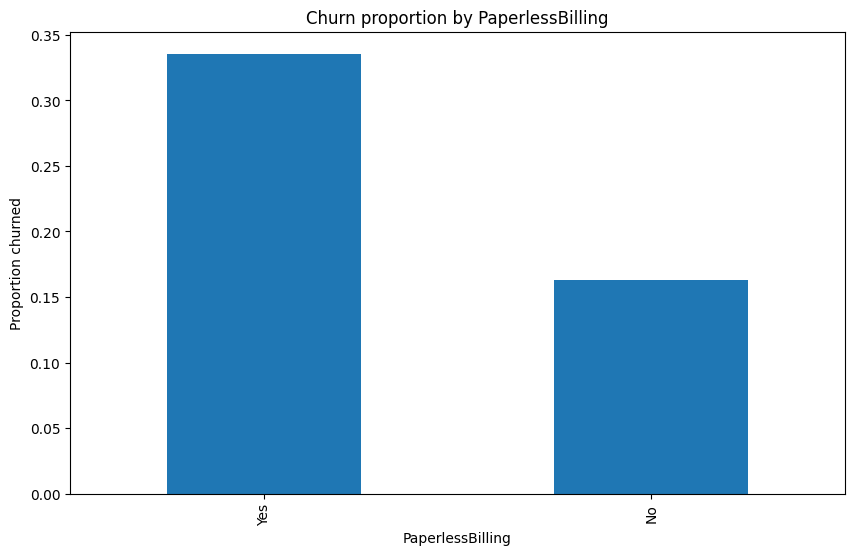

Churn,No,Yes
PaymentMethod,,
Bank transfer (automatic),0.832902,0.167098
Credit card (automatic),0.847569,0.152431
Electronic check,0.547146,0.452854
Mailed check,0.808933,0.191067


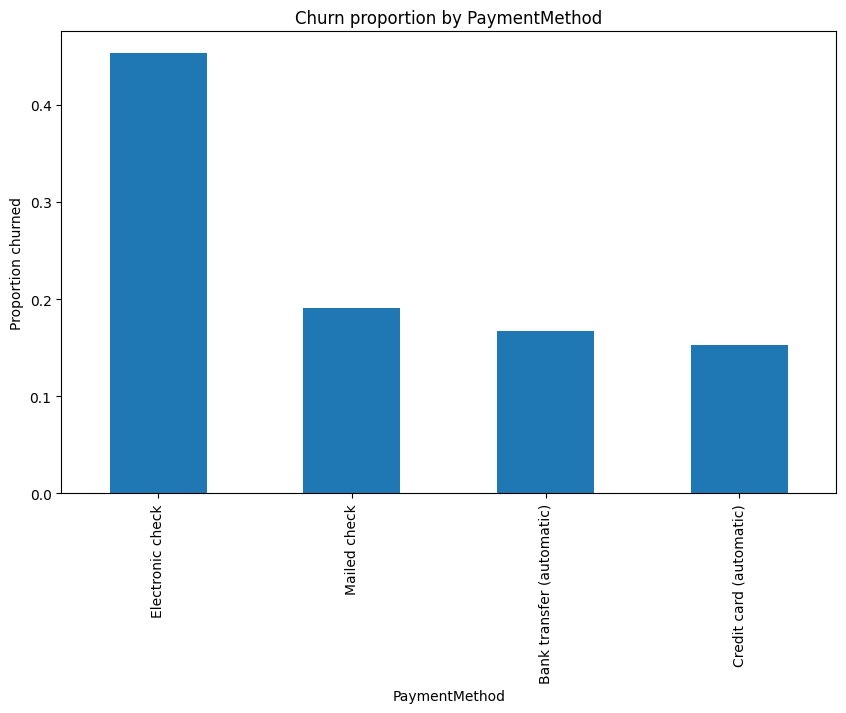

Churn,No,Yes
Churn,,
No,1.0,0.0
Yes,0.0,1.0


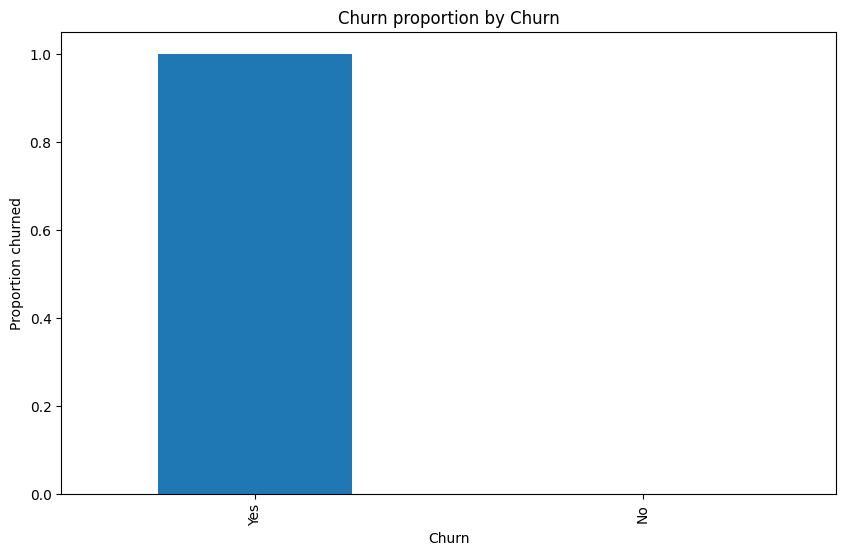

In [41]:
cat_cols = [c for c in df.columns if df[c].dtype == 'object' and c != 'customerID']
for col in cat_cols:

    # churn rate per category - fixed approach
    churn_by_cat = pd.crosstab(df[col], df['Churn'], normalize='index')
    display(churn_by_cat)
    
    # quick bar: churn 'Yes' proportion by category
    if 'Yes' in churn_by_cat.columns:
        churn_prop = churn_by_cat['Yes'].sort_values(ascending=False)
        churn_prop.plot(kind='bar')
        
        plt.title(f'Churn proportion by {col}')
        plt.ylabel('Proportion churned')
        plt.show()

#### 1.3.4 Feature engineering

- tenure_group (New customer, 0-12, 12-24, 24-48, 48+)
- services_count: count how many "Yes" service fields a user has in here
- monthly_to_total_ratio = MonthlyCharges / (TotalCharges/tenure) — careful of zero/NaN

implement examples

In [42]:
bins = [0,1,12,24,48,999]
labels = ['0 months','1-12','13-24','25-48','48+']
df['tenure_group'] = pd.cut(df['tenure'], bins=bins, labels=labels, include_lowest=True)

# services count
service_flags = df[SERVICES].apply(lambda x: x.map({'Yes':1,'No':0,'No phone service':0,'No internet service':0}))
df['services_count'] = service_flags.sum(axis=1)

# safe monthly/average charge
df['avg_charge_per_month'] = df['TotalCharges'] / df['tenure'].replace(0, np.nan)

print('\nCreated tenure_group, services_count, avg_charge_per_month (NaN if tenure=0)')


Created tenure_group, services_count, avg_charge_per_month (NaN if tenure=0)


### 1.4 Comprehensive Bivariate Analysis

- Churn vs Demographics, Services, Financial
- Statistical significance: Chi-square for categorical, t-test for numeric

#### 1.4.1 Churn vs demographics: ex- Age proxy SeniorCitizen and Partner


Churn proportions by gender


Churn,No,Yes
gender,,
Female,0.730791,0.269209
Male,0.738397,0.261603


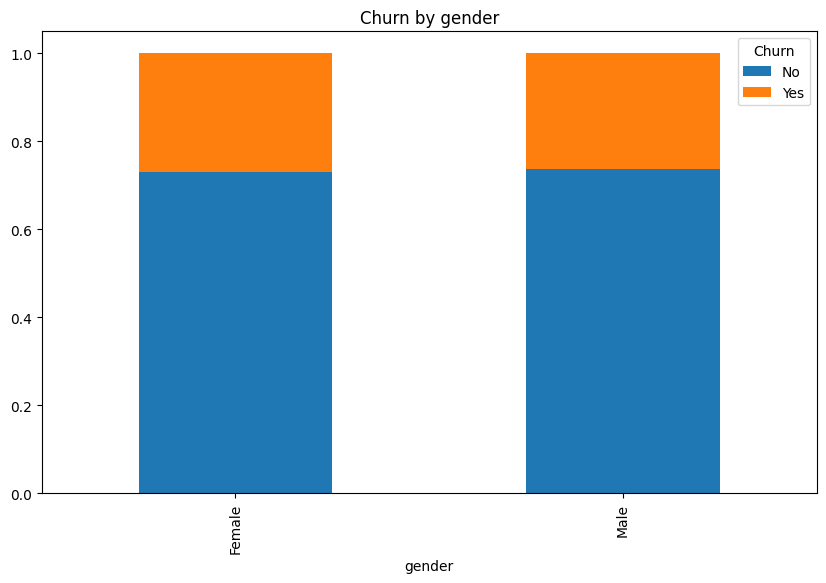


Churn proportions by SeniorCitizen


Churn,No,Yes
SeniorCitizen,,
0,0.763938,0.236062
1,0.583187,0.416813


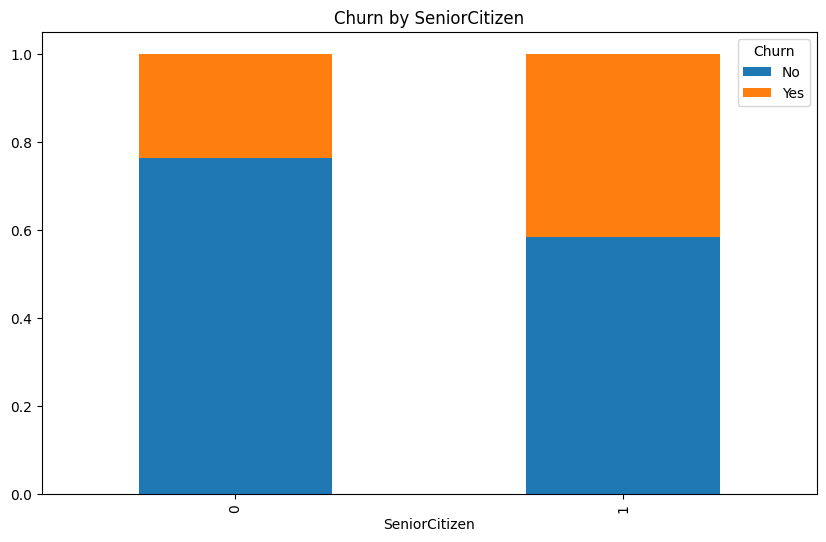


Churn proportions by Partner


Churn,No,Yes
Partner,,
No,0.670420,0.329580
Yes,0.803351,0.196649


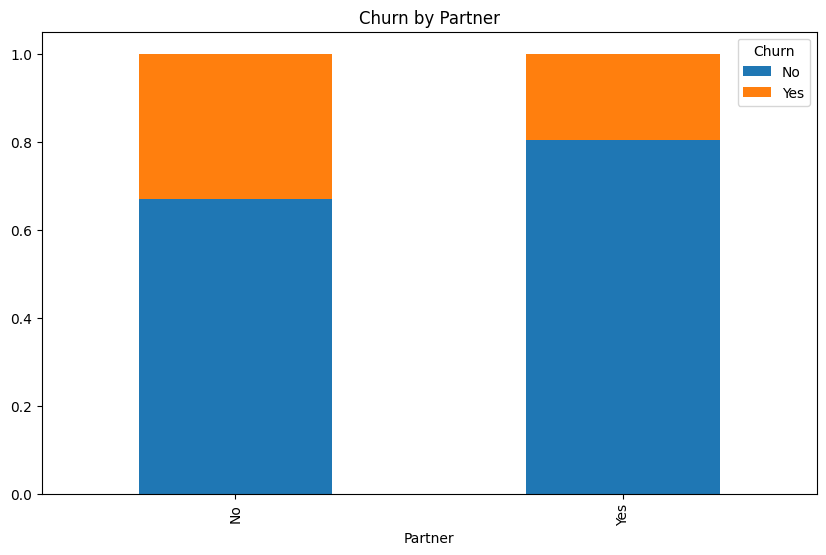


Churn proportions by Dependents


Churn,No,Yes
Dependents,,
No,0.687209,0.312791
Yes,0.845498,0.154502


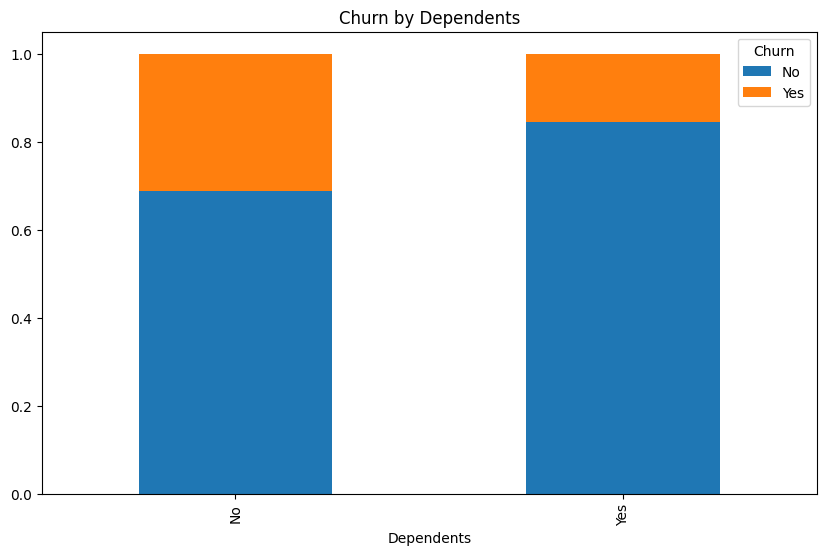

In [43]:
for col in DEMOGRAPHIC:
    ct = pd.crosstab(df[col], df['Churn'], normalize='index')
    print('\nChurn proportions by', col)
    display(ct)
    ct.plot(kind='bar', stacked=True)
    plt.title(f'Churn by {col}')
    plt.show()

#### 1.4.2 Churn vs services: heatmap of churn rates for service features

In [44]:
service_churn = {}

for s in SERVICES:
    
    # First we check if the service has 'Yes' values
    if df[s].eq('Yes').any():
        
        # Get the churn rate for customers who have this service ('Yes')
        service_users = df[df[s] == 'Yes']
        churn_rate = service_users[service_users['Churn'] == 'Yes'].shape[0] / service_users.shape[0]
        service_churn[s] = churn_rate
        
    else:
        
        # If service doesn't have 'Yes' values (different values like 'No internet service' or other)
        service_churn[s] = np.nan

print('\nApprox churn rate when service is Yes:')
print(pd.Series(service_churn).sort_values(ascending=False))


Approx churn rate when service is Yes:
StreamingTV         0.300702
StreamingMovies     0.299414
MultipleLines       0.286099
PhoneService        0.267096
DeviceProtection    0.225021
OnlineBackup        0.215315
TechSupport         0.151663
OnlineSecurity      0.146112
InternetService          NaN
dtype: float64


#### 1.4.3 Churn vs financial (t-tests)

- Compare MonthlyCharges between churners and non-churners

In [45]:
churn_yes = df[df['Churn']=='Yes']['MonthlyCharges'].dropna()
churn_no = df[df['Churn']=='No']['MonthlyCharges'].dropna()
print('MonthlyCharges mean - churners: {:.2f}, non-churners: {:.2f}'.format(churn_yes.mean(), churn_no.mean()))

t_stat, p_val = stats.ttest_ind(churn_yes, churn_no, equal_var=False)
print('T-test for MonthlyCharges (Yes vs No): t={:.3f}, p={:.5f}'.format(t_stat, p_val))

# For TotalCharges
ch_y = df[df['Churn']=='Yes']['TotalCharges'].dropna()
ch_n = df[df['Churn']=='No']['TotalCharges'].dropna()

if len(ch_y) > 0 and len(ch_n) > 0:
    t_stat2, p_val2 = stats.ttest_ind(ch_y, ch_n, equal_var=False)
    print('T-test for TotalCharges: t={:.3f}, p={:.5f}'.format(t_stat2, p_val2))

MonthlyCharges mean - churners: 74.44, non-churners: 61.27
T-test for MonthlyCharges (Yes vs No): t=18.408, p=0.00000
T-test for TotalCharges: t=-18.801, p=0.00000


#### 1.4.4 Chi-square tests for categorical features vs churn

In [46]:
for col in ['Contract','PaymentMethod','InternetService','SeniorCitizen']:
    ct = pd.crosstab(df[col], df['Churn'])
    chi2, p, dof, ex = chi2_contingency(ct)
    
    print('\nChi-square for', col, ': p-value =', p)


Chi-square for Contract : p-value = 5.863038300673391e-258

Chi-square for PaymentMethod : p-value = 3.6823546520097993e-140

Chi-square for InternetService : p-value = 9.571788222840544e-160

Chi-square for SeniorCitizen : p-value = 1.510066805092378e-36


### 1.5 Multivariate Analysis

- Correlation matrix (numerical) and multicollinearity (VIF)
- Feature interactions: example Contract + PaymentMethod pivot
- Customer segmentation (k-means clustering example)

#### 1.5.1 Correlation matrix for numeric features

Numeric columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'services_count', 'avg_charge_per_month']


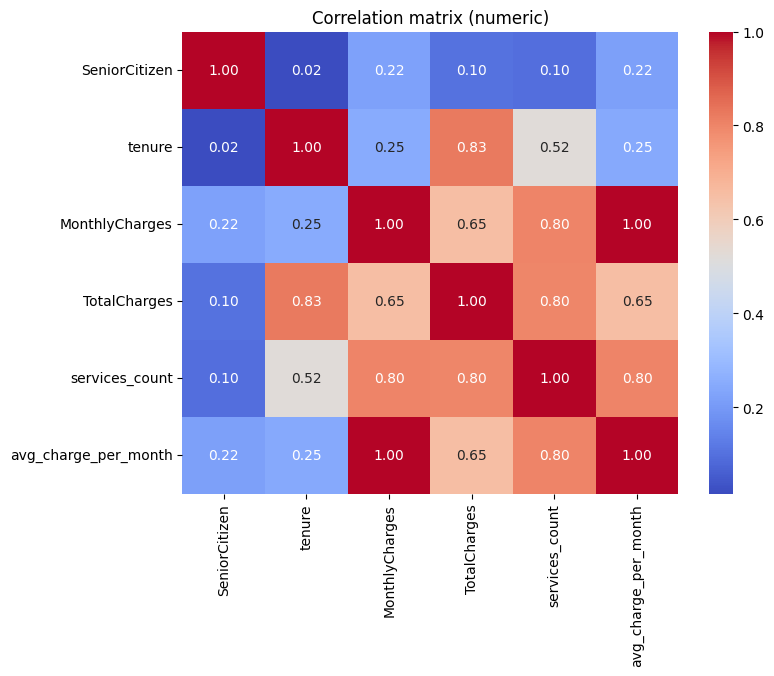

In [47]:
numeric = df.select_dtypes(include=[np.number]).columns.tolist()
print('Numeric columns:', numeric)

corr = df[numeric].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation matrix (numeric)')
plt.show()

#### 1.5.2 VIF to check multicollinearity

- Prepare df for VIF: drop NaNs and the target3

In [48]:
vif_df = df[numeric].dropna()
X = vif_df.copy()
X['Intercept'] = 1
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data.sort_values('VIF', ascending=False).head())

                feature         VIF
2        MonthlyCharges  135.058812
5  avg_charge_per_month  133.918355
6             Intercept   15.043358
3          TotalCharges   10.337362
1                tenure    5.888614


#### 1.5.3 Feature interactions: Contract x PaymentMethod churn heatmap

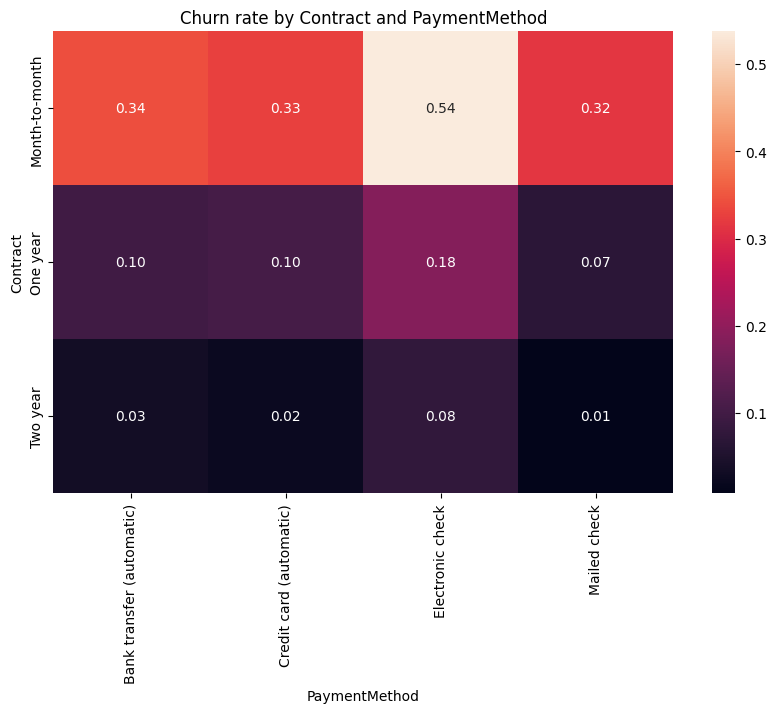

In [49]:
pivot = df.pivot_table(index='Contract', columns='PaymentMethod', values='Churn', aggfunc=lambda x: (x=='Yes').mean())
plt.figure()
sns.heatmap(pivot, annot=True, fmt='.2f')
plt.title('Churn rate by Contract and PaymentMethod')
plt.show()

#### 1.5.4 Customer segmentation (simple KMeans on scaled numeric features)

In [50]:
seg_features = ['tenure','MonthlyCharges','TotalCharges','services_count']
seg_df = df[seg_features].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(seg_df)

lets try k=2..6 and use silhouette

In [51]:
sil_scores = {}
for k in range(2,7):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    sil_scores[k] = sil

print('Silhouette scores for k=2..6:', sil_scores)
best_k = max(sil_scores, key=sil_scores.get)
print('Best k by silhouette:', best_k)

km = KMeans(n_clusters=best_k, random_state=42)
seg_labels = km.fit_predict(X_scaled)
seg_df['segment'] = seg_labels
seg_summary = seg_df.groupby('segment').mean()
print('\nSegment centers (scaled features mean):')
print(seg_summary)

  File "c:\Users\dneth\anaconda3\envs\newone\Lib\site-packages\joblib\externals\loky\backend\context.py", line 227, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\dneth\anaconda3\envs\newone\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\dneth\anaconda3\envs\newone\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\dneth\anaconda3\envs\newone\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Silhouette scores for k=2..6: {2: 0.4669612113341435, 3: 0.4120424320943256, 4: 0.41846725263538415, 5: 0.38709360360544387, 6: 0.37348387788373794}
Best k by silhouette: 2

Segment centers (scaled features mean):
            tenure  MonthlyCharges  TotalCharges  services_count
segment                                                         
0        54.488800       90.265740   4899.321420        5.518800
1        20.248897       50.749481    840.217376        2.174316


### 1.6 Business Insights Generation

- Identify high-risk profiles
- Retention opportunities and revenue impact

#### 1.6.1 High-risk profiles: top features associated with churn (simple ranking by difference in proportion)

In [52]:
cat_cols_for_ranking = ['Contract','InternetService','PaymentMethod','tenure_group']
risk_summary = []
for col in cat_cols_for_ranking:
    prop = df.groupby(col)['Churn'].value_counts(normalize=True).unstack().fillna(0)
    if 'Yes' in prop.columns:
        prop = prop['Yes']
        top = prop.sort_values(ascending=False).head(3)
        for idx, val in top.items():
            risk_summary.append((col, idx, val))

risk_df = pd.DataFrame(risk_summary, columns=['feature','category','churn_rate'])
print('Top high-risk categories:')
print(risk_df)

Top high-risk categories:
            feature                   category  churn_rate
0          Contract             Month-to-month    0.427097
1          Contract                   One year    0.112695
2          Contract                   Two year    0.028319
3   InternetService                Fiber optic    0.418928
4   InternetService                        DSL    0.189591
5   InternetService                         No    0.074050
6     PaymentMethod           Electronic check    0.452854
7     PaymentMethod               Mailed check    0.191067
8     PaymentMethod  Bank transfer (automatic)    0.167098
9      tenure_group                   0 months    0.608974
10     tenure_group                       1-12    0.420615
11     tenure_group                      13-24    0.287109


#### 1.6.2 Retention opportunities & Revenue impact estimate

Example: compute average monthly revenue lost if all churners in dataset left

In [53]:
avg_monthly_revenue = df['MonthlyCharges'].mean()
churners = df[df['Churn']=='Yes']
monthly_revenue_lost = churners['MonthlyCharges'].sum()
annual_revenue_lost = monthly_revenue_lost * 12

print('Number of churners:', len(churners))
print('Estimated monthly revenue lost (current churners): ${:,.2f}'.format(monthly_revenue_lost))
print('Estimated annualized revenue lost: ${:,.2f}'.format(annual_revenue_lost))

# More targeted: if customers with month-to-month contract churn at observed rate, calculate revenue at risk
m2m = df[df['Contract']=='Month-to-month']
m2m_churn_rate = (m2m['Churn']=='Yes').mean()
m2m_monthly_revenue = m2m['MonthlyCharges'].sum()
print('\nMonth-to-month subset size:', len(m2m), 'churn rate:', m2m_churn_rate)
print('Revenue from Month-to-month customers (monthly): ${:,.2f}'.format(m2m_monthly_revenue))
print('Estimated monthly revenue at risk (if churn rate persists): ${:,.2f}'.format(m2m_monthly_revenue * m2m_churn_rate))

Number of churners: 1869
Estimated monthly revenue lost (current churners): $139,130.85
Estimated annualized revenue lost: $1,669,570.20

Month-to-month subset size: 3875 churn rate: 0.4270967741935484
Revenue from Month-to-month customers (monthly): $257,294.15
Estimated monthly revenue at risk (if churn rate persists): $109,889.50


In [ ]:
cleaned_path = 'src/data/processed/telco-customer-churn_cleaned.csv'
df.to_csv(cleaned_path, index=False)

print('Saved cleaned dataframe to', cleaned_path)

Saved cleaned dataframe to data/processed/telco-customer-churn_cleaned.csv
